## Emotion recognition on twitter

1. After browsing the same Kaggle competetion last year, I figured out that my desired score on public leaderboard will be around __55 - 58__. Since there are only small changes between Public and Private leaderboard rankings, my score on the public dataset will be a very reliable indicator for my model proformance.


2. Following code represent the prediction for our test dataset, if you want to know how I train the model, please go to another file called `Gen_model.py`. Since our training dataset is very large (1455563 data), so I took 5% of training data as my validation data to evaluate the model proformance.


3. `Gen_model.py` was run on my lab server with GeForce RTX 2080 Ti(11GB), it took approximately __6 hours__ to train an epoch.


4. The best score I recieved on public leaderboard is __0.56555__.

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, random_split,  SequentialSampler
from transformers import BertForSequenceClassification,RobertaForSequenceClassification, AdamW, BertConfig
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
import random
import numpy as np
import os
import regex as re
from tqdm import tqdm
from dataset import TweetDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device: ', device)

Using device:  cuda


### Preprocess - data cleaning ( Noted that content of tweets are too noisy )

- I reckon that too much preprocess will decimate the expression of our tweets. So I just did some simple action to eliminate unnecessary content. 

In [3]:
#df_final['text'] = df_final['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('<lh>', '').str.strip()
def preprocess_tweets(df):
    # convert to lower case
    df['text'] = df.text.str.lower()
    # remove links
    df.text = df.text.apply(lambda x: re.sub(r'https?:\/\/\S+', 'http', x))
    df.text = df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
    df.text = df.text.apply(lambda x: re.sub(r'{link}', '', x))
    df.text = df.text.apply(lambda x: re.sub(r"\[video\]", '', x))
    # substitute 'RT @' with '@'
    df.text = df.text.apply(lambda x: re.compile('rt @').sub('@', x).strip())
    # Remove usernames. The usernames are any word that starts with @.
    df.text = df.text.apply(lambda x: re.sub('\@[a-zA-Z0-9]*', '@user', x))
    # convert '#' to '' and '_' to ' ' and ':' to ''
    df.text = df.text.apply(lambda x: x.replace("<lh>", ''))
    return df

In [4]:
# read our data
data_path = './data/'
data_id = pd.read_csv(data_path + 'data_identification.csv')
emotions = pd.read_csv(data_path + 'emotion.csv')
sample_sub = pd.read_csv(data_path + 'sampleSubmission.csv')
tweets = pd.read_json(data_path + 'tweets_DM.json', lines=True)
tweets_important = pd.DataFrame(tweets._source)

In [5]:
# Create a final dataframe from all of the data sources
tw_list = tweets_important['_source'].to_list()
tmp_df = pd.DataFrame.from_records(tw_list)
tmp_df_list = tmp_df['tweet'].to_list()
final_tweet_df = pd.DataFrame.from_records(tmp_df_list)
df_final = pd.merge(final_tweet_df, data_id, how='outer', on='tweet_id').merge(emotions, how='outer', on='tweet_id')

In [6]:
df_final

,hashtags,tweet_id,text,identification,emotion
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test,NaN
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
4,[],0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN
...,...,...,...,...,...
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...,test,NaN
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...,test,NaN
1867532,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,test,NaN
1867533,[],0x24faed,"Ah, corporate life, where you can date <LH> us...",train,joy


In [7]:
# Apply preprocess on our data
df_final  = preprocess_tweets(df_final)
df_final.text[0:20]

0     people who post "add me on #snapchat" must be ...
1     @user as we see, trump is dangerous to #freepr...
2     confident of your obedience, i write to you, k...
3                       now issa is stalking tasha 😂😂😂 
4     "trust is not the same as faith. a friend is s...
5     @user @user thx for the best time tonight. wha...
6              still waiting on those supplies liscus. 
7                             love knows no gender. 😢😭 
8     @user @user more highlights are being shown th...
9     when do you have enough ? when are you satisfi...
10    the #ssm debate;  (a manufactured fantasy used...
11    i love suffering 🙃🙃 i love when valium does no...
12    can someone tell my why my feeds scroll back t...
13    you know you research butterflies when predict...
14    my brother didn't tell me he was going to horr...
15    on a scale of kylie jenner-heidi klum, i consi...
16    progress at house meyer, pre galv sub frame go...
17        vomi post birthday celebrations! #late

### Demonstration of RoBERTa tokenizer
 #### Why do I choose __RoBERTa__ as our model?
  - Firstly, RoBERTa is a much robust model training with more data as its name tells. Secondly, its tokenizer can deal with __emoji__, which I think is very important to infer the emotion of tweets. On the other hand, BERT cannot deal tokenize the emoji, and that's the reason I chose RoBERTa over BERT.

In [10]:
tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

In [12]:
# Roberta tokenizer can handle with emoji
print('Original text: ', df_final.text[11])
tok = tokenizer_roberta.encode(df_final.text[11])
tok2 = tokenizer_bert.encode(df_final.text[11])
print('Using roberta tokenizer: \n', tokenizer_roberta.decode(tok))
print('Using bert tokenizer: \n', tokenizer_bert.decode(tok2))

Original text:  i love suffering 🙃🙃 i love when valium does nothing to help 🙃🙃 i love when my doctors say that they've done all they can 🙃🙃 
Using roberta tokenizer: 
 <s>i love suffering 🙃🙃 i love when valium does nothing to help 🙃🙃 i love when my doctors say that they've done all they can 🙃🙃 </s>
Using bert tokenizer: 
 [CLS] i love suffering [UNK] i love when valium does nothing to help [UNK] i love when my doctors say that they've done all they can [UNK] [SEP]


### Hash tag enhancement (optional)

In [32]:
'''
df_final['hashtags'] = df_final.hashtags.apply(lambda t: ' '.join(t))
df_final['text'] = df_final['text'] + ' ' + df_final['hashtags']
df_final['text']
'''

"\ndf_final['hashtags'] = df_final.hashtags.apply(lambda t: ' '.join(t))\ndf_final['text'] = df_final['text'] + ' ' + df_final['hashtags']\ndf_final['text']\n"

### Train - Test split 

In [8]:
# Separate training from testing data
train_df = df_final[df_final['identification'] == 'train']
test_df = df_final[df_final['identification'] == 'test']
# size of training and testing data
print('TRAIN DATA shape:', train_df.shape)
print('TEST DATA shape:', test_df.shape)

TRAIN DATA shape: (1455563, 5)
TEST DATA shape: (411972, 5)


### Visualize our data

I observed a long-tailed distribution, so maybe using __weighted average loss function__ will be a good idea. But after eperiment, it didn't yeild a better score.

<AxesSubplot:>

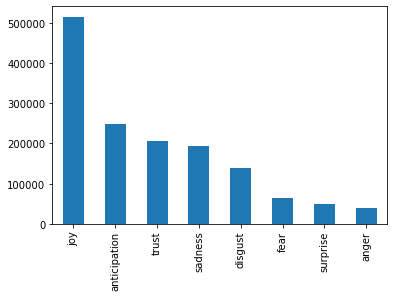

In [9]:
# Let's have a look at the distribution of the training data with respect to our targets

train_df.emotion.value_counts().plot(kind='bar')


### I was wondering the max length of the tweet

In [10]:
df_final['len'] = df_final.text.apply(lambda t:len(t))
df_final.len.max()

248

In [11]:
df_final2 = df_final[df_final['len'] > 150]
df_final2

,hashtags,tweet_id,text,identification,emotion,len
85809,[],0x2489ba,similar to &lt;aung san suu kyi&gt; the &lt;do...,train,surprise,154
166030,"[Bajrangi, Sultan, Wanted, Dabangg, EkThaTiger...",0x2e7cbd,"for me, #bajrangi &gt; #sultan &gt; #wanted &...",train,trust,163
171258,[],0x28abe1,"a sunday reflection:&gt;""#ancestralwisdomwithh...",train,anticipation,158
240753,[],0x2cf4b8,dealing with an unhandled error because the ap...,train,disgust,152
249676,"[Celtics, kyrieirvingtrade, offseason]",0x32254f,#celtics #kyrieirvingtrade i get from work 2 ...,train,disgust,160
285588,"[Soul_Thought, Divine_Intervention, ASK]",0x3700c1,#soul_thought &lt;&gt; let us &lt;&gt; night ...,train,anticipation,153
302246,"[YOU, ASSHOLE, TO]",0x2fa333,"@user@user###@user@user ""despise & fuckin ha...",train,disgust,153
328603,[],0x200fd4,"&gt;goes to gym. &gt;ahh, good workout. &gt;...",train,trust,163
345801,"[NOW, I, DEFINITLY, YEP, IT, HAPPEND]",0x34987b,"@user #now #i""m #definitly @user @user...... ...",train,trust,192
415549,[],0x30024e,"a reflection:&gt;""#southeastasianethniccleansi...",train,disgust,155


### LOAD MODEL

In [20]:
# Load the model and tokenizer we pretrain

output_dir = './model_save/robert_lite_ep4'
model = RobertaForSequenceClassification.from_pretrained(output_dir, num_labels = 8, 
                                                            output_attentions = False, 
                                                            output_hidden_states = False)
tokenizer = AutoTokenizer.from_pretrained(output_dir, use_fast=False)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

## Evaluate on Test Set

Document suggests that training epcoh should be around 2 - 4 to get a better proformance.

1. Using **bert-base-uncased model** training with 4 epochs -> 0.47927

2. Using **bert-base-uncased model** training with 4 epochs + hashtag concatenation -> 0.53676

3. Using **reoberta-base** training wih 2 epochs -> 0.56246

4. Using **reoberta-base** training wih 4 epochs -> 0.56555


In [21]:
batch_size = 16
tweet_id = test_df['tweet_id'].values
prediction_data = TweetDataset(test_df, 'test', tokenizer)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Start predicting

In [22]:
print('Predicting labels for {:,} test sentences...'.format(len(tweet_id)))


# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , pred_ID = [], []

# Predict 
for batch in tqdm(prediction_dataloader):
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask = b_input_mask, return_dict = False)

    logits = outputs[0]

  # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

  # Store predictions and true labels
    predictions.append(logits)

print('    DONE.')

Predicting labels for 411,972 test sentences...


  0%|                                                             | 0/25749 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/james/anaconda3/envs/py36/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  Fu

    DONE.


In [23]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
print(flat_predictions)


[0 4 1 ... 3 1 3]


In [24]:
print(len(flat_predictions))
print(len(tweet_id))

411972
411972


In [25]:
label_map = {'anticipation': 0, 'joy': 1, 'disgust': 2, 'sadness': 3, 'trust': 4, 'fear': 5, 'surprise': 6, 'anger': 7}
index_map = {v: k for k, v in label_map.items()}
index_map

{0: 'anticipation',
 1: 'joy',
 2: 'disgust',
 3: 'sadness',
 4: 'trust',
 5: 'fear',
 6: 'surprise',
 7: 'anger'}

In [26]:
final_predictions = [index_map[k] for k in flat_predictions]
ID_EMO = dict(zip(tweet_id, final_predictions))
sample_sub['emotion'] = sample_sub.id.apply(lambda t: ID_EMO[t])
sample_sub.to_csv('sub.csv', index=False)  
sample_sub[0:10]

,id,emotion
0,0x2c7743,joy
1,0x2c1eed,anticipation
2,0x2826ea,sadness
3,0x356d9a,joy
4,0x20fd95,joy
5,0x1dff4a,sadness
6,0x243512,joy
7,0x27aa7d,anticipation
8,0x1e983c,joy
9,0x1e55ec,joy
